In [1]:
%%capture 
!pip install transformers
!pip install datasets

In [2]:
from datasets import load_dataset
import torch 
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F

from functools import partial

In [3]:
dataset = load_dataset("mnist")
train_d = dataset['train']
train_v = dataset['test']

class Dataset():
    def __init__(self, x, y): 
      self.x,self.y = x,y
    def __len__(self): 
      return len(self.x)
    def __getitem__(self, i): 
      return { "x" : torch.tensor(np.array(self.x[i])[None] , dtype = torch.float),"y" :torch.tensor(self.y[i])}

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_dataset = Dataset(train_d['image'] , train_d['label'])
val_dataset = Dataset(train_v['image'] , train_v['label'])

In [5]:
train_dataloader = DataLoader(train_dataset , batch_size=256)
val_dataloader = DataLoader(val_dataset , batch_size=256)

In [6]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res
def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList(cnn_layers())
    self.layer_means = [ [] for _ in range(6)]
    self.layer_std = [ [] for _ in range(6)]
  
  def __call__(self , x):
    for i, l in enumerate(self.layers):
      x = l(x)
      
      self.layer_means[i].append(x.detach().cpu().numpy().mean())
      self.layer_std[i].append(x.detach().cpu().numpy().std())
    return x

In [7]:
import tqdm

def fit(model,train_dataloader , val_dataloader , loss_func ,optimizer,epochs,device):
  for epoch in range(epochs):
    with tqdm.tqdm(total=len(train_dataloader), desc=" Train :: Epoch {}/{}".format(epoch + 1, epochs)) as pbar:
      model.train()
      for batch in train_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        pred = model(x)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)
    with tqdm.tqdm(total=len(train_dataloader), desc=" Val :: Epoch {}/{}".format(epoch + 1, epochs)) as pbar:
      model.eval()
      with torch.no_grad():
        for batch in train_dataloader:
          x = batch['x'].to(device)
          y = batch['y'].to(device)
          pred = model(x)
          loss = loss_func(pred,y)
          pbar.set_postfix({"loss": loss.item()})
          pbar.update(1)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model().to(device)

opt = torch.optim.SGD(model.parameters() , lr =.01)
fit(model , train_dataloader , val_dataloader , F.cross_entropy , opt , 3 , device )

 Val :: Epoch 3/3: 100%|██████████| 235/235 [00:06<00:00, 38.89it/s, loss=0.125]


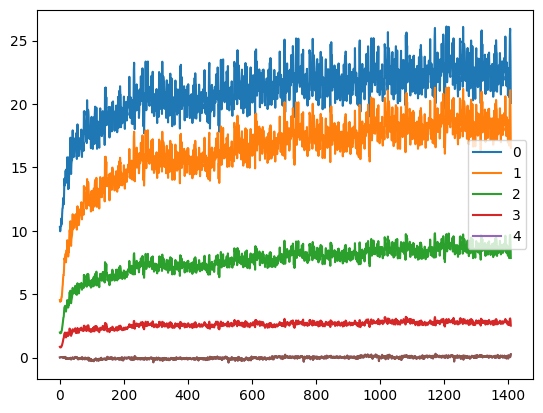

In [9]:
import matplotlib.pyplot as plt

for l in model.layer_means: 
  plt.plot(l)
plt.legend(range(5) , loc='right');

## using PyTorch hooks 

In [10]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList(cnn_layers())
  def __call__(self , x):
    for i, l in enumerate(self.layers):
      x = l(x)
    return x
  def __iter__(self):
    return iter(self.layers)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model().to(device)

layer_means = [[] for _ in model]
layer_stds  = [[] for _ in model]

def append_(i, module, input, output):
    layer_means[i].append(output.detach().cpu().numpy().mean())
    layer_stds [i].append(output.detach().cpu().numpy().std())
    
for i,m in enumerate(model): 
   m.register_forward_hook(partial(append_, i))

In [11]:
opt = torch.optim.SGD(model.parameters() , lr =.01)
fit(model , train_dataloader , val_dataloader , F.cross_entropy , opt , 3 , device )

 Val :: Epoch 3/3: 100%|██████████| 235/235 [00:04<00:00, 47.18it/s, loss=0.124]


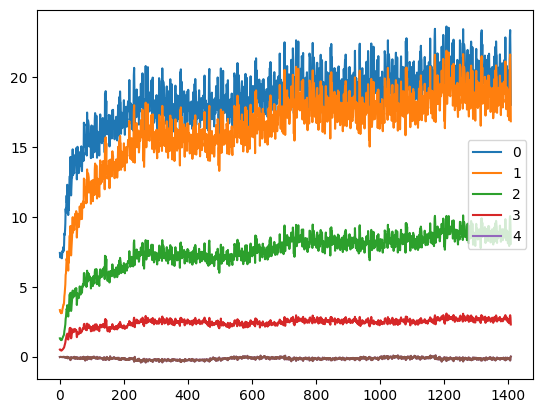

In [12]:
for o in layer_means: plt.plot(o)
plt.legend(range(5),loc='right');
